<a href="https://colab.research.google.com/github/olgOk/Adaptive_QNG/blob/dev_olga/TIF_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install qiskit 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 6.4 MB/s 
     |████████████████████████████████| 12.8 MB 51.6 MB/s 
     |████████████████████████████████| 240 kB 59.4 MB/s 
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 106 kB 56.5 MB/s 
     |████████████████████████████████| 50 kB 3.9 MB/s 
     |████████████████████████████████| 929 kB 53.1 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 4.0 MB 52.1 MB/s 
     |████████████████████████████████| 1.9 MB 75.5 MB/s 
     |████████████████████████████████| 112 kB 70.5 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=5af22a427c9981545b9d167876cad99917da6edbaff29a97ff85cf3d218b4773
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa04

In [2]:
!python3 -m pip install qiskit_ibm_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 190 kB 5.3 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 237 kB 9.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 140 kB 63.6 MB/s 
     |████████████████████████████████| 83 kB 2.2 MB/s 
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.30.2-py3-none-any.whl size=251991 sha256=b4bb5db8c7d1209298e143db4be8f8c50e1d649b3d8656e8f68ff390f83de42f
  Stored in directory: /root/.cache/pip/wheels/d0/18/32/cf13b0245c4d953cc0074b616c86f80751a6050d826ba75e27
Successfully built ibm-platform-services
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-

In [3]:
!python3 -m pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.9 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=756237fb7bdb2fc3e6aa45fea615663b3987eaca4a55c446c1bf93bdcb470dc3
  Stored in directory: /root/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc


In [4]:
# imports
import time
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit.tools.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
# %config InlineBackend.figure_format='retina'

## Using Qiskit opflow

In [5]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP, GradientDescent, AQGD
from qiskit.circuit.library import TwoLocal
from qiskit.opflow.gradients import Gradient, NaturalGradient
from qiskit.opflow import X, Z, I
from qiskit.utils import algorithm_globals
import matplotlib.pyplot as plt

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=800, seed_simulator=99)

Prepare Hamiltonian using [Qiskit Opflow Operators](https://qiskit.org/documentation/apidoc/opflow.html)

$H = 0.4Z_1I_2 + 0.4I_1Z_2 + 0.2X_1X_2 = 0.4(Z_1I_2 + I_1Z_2) +  0.2X_1X_2$

In [6]:
H_model = (0.4 * I ^ Z) + (0.4 * Z ^ I) + (0.2 * X ^ X)

## Anzatz 

Create an ansatz using Qiskit [RealAmplitude](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) with 2 qubits and 1 repetition of rotation gates.
The total number of parameters is $2×(1+1) = 4$ (e.g. 2qubits 1 repetition)

In [7]:
seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

# define ansatz as RealAmplitude as described in research paper
ansatz = RealAmplitudes(2, reps=1)

Use [AQGD (Adaptive Quantum Gradient Descent)](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/aqgd.py) avaliable in the qiskit.optimizers module. 

In [8]:
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(H_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 234,
    'eigenstate': array([-1.22377103e-01+0.j, -5.29522800e-05+0.j, -9.46990056e-05+0.j,
        9.92483669e-01+0.j]),
    'eigenvalue': (-0.8246210505013534+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[2]): 0.40642989033244203,
                              ParameterVectorElement(θ[1]): 2.1356234787788346,
                              ParameterVectorElement(θ[3]): 2.0849262194478078,
                              ParameterVectorElement(θ[0]): 2.6705484338423497},
    'optimal_point': array([2.67054843, 2.13562348, 0.40642989, 2.08492622]),
    'optimal_value': -0.8246210505013534,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': 0.5359606742858887}


# Transverse Field Ising Model

Fix the value of the parameter t, $t=0.1$, while vary the value of the parameter N, $N$ is in the interval $ [2, 10 ] $.

In [9]:
#N = 2, t = 0.1

t = 0.1

TFI_model = -1*(( I ^ Z ^ Z) + ( Z ^ Z ^ I)) +  t * ((I ^ I ^ X)  + (I ^ X ^ I))


# N = 3, t = 0.1 

# TFI_model = -1*((I ^ I ^ Z ^ Z) + (I ^ Z ^ Z ^ I) + (Z ^ Z ^ I ^ I) +  0.1 * (I^I^I ^ X) + 0.1 * (I^I^X ^ I) + 0.1 * (I ^ X ^ I ^ I))

A test run for the $N=2$.

In [10]:
ansatz = RealAmplitudes(3, reps=1)
optimizer = AQGD(maxiter=1000)
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(TFI_model)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 481,
    'eigenstate': array([-1.34716598e-03+0.j,  5.86204874e-04+0.j, -3.02574263e-05+0.j,
       -2.58541878e-05+0.j,  3.73254143e-03+0.j, -2.50070754e-02+0.j,
       -4.99209125e-02+0.j,  9.98431999e-01+0.j]),
    'eigenvalue': (-2.0075040208858406+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 1.5763277166925642,
                              ParameterVectorElement(θ[0]): -2.030657752942106,
                              ParameterVectorElement(θ[2]): -1.573734495389854,
                              ParameterVectorElement(θ[3]): 1.210968996051247,
                              ParameterVectorElement(θ[4]): -1.5229208980439424,
                              ParameterVectorElement(θ[5]): -1.5707245969502666},
    'optimal_point': array([-2.03065775,  1.57632772, -1.5737345 ,  1.210969  , -1.5229209 ,
       -1.5707246 ]),
    'optimal_value': -2.0075040208858406,
    'opti

### Setup 1. Fixed Ansatz

In [11]:
# define callback information

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [12]:
from pygments.formatters import TerminalFormatter
t = 0.1

def construct_ising(N, layer_repeat):
  """
    Construct the Transverse Field Ising Model depending on the N
    Args:
      N: (int), number of the 
  """

  # ising_ham1 = [( -1 * ( (I^(N-1 - a))^( Z ^ (2)) ^ (I ^ (a))) ) for a in range(0, N)]

  # ising_ham2 = [ t * (I ^ (N-a) ^ X ^ (I^(a))) for a in range(0, N)]

  # TFI_model = sum(ising_ham1, ising_ham2)

  TFI_model = []

  for a in range (0, N):
    ising_ham1 = ( -1 * ( (I^(N-1 - a))^( Z ^ (2)) ^ (I ^ (a))) )
    ising_ham2 =  t * (I ^ (N-a) ^ X ^ (I^(a)))
    TFI_model.append(ising_ham1)
    TFI_model.append(ising_ham2)

  TFI_model = sum(TFI_model)


  ansatz = RealAmplitudes(N+1, reps=layer_repeat)
  np.random.seed()
  initial_point = np.random.random(ansatz.num_parameters)
  optimizer = AQGD(maxiter=1000)
  vqe = VQE(ansatz=ansatz, optimizer=optimizer, initial_point=initial_point, quantum_instance=qi, callback=callback)
  result = vqe.compute_minimum_eigenvalue(TFI_model)
  # print(result)

  return result


In [13]:
N = [n for n in range(2, 11, 1)]

energy = []

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy.append(result.optimal_value)

energy

[-2.0075045766962485,
 -3.010006195401387,
 -4.01250775807701,
 -5.015009320587273,
 -6.017510883099822,
 -7.020012445591408,
 -8.0225140081111,
 -9.025015570617382,
 -10.027517133115571]

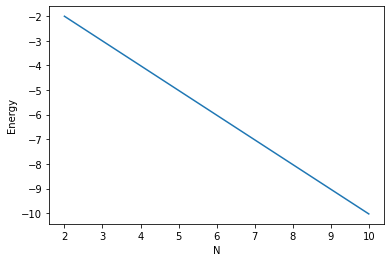

In [14]:
plt.ylabel('Energy')
plt.xlabel('N')
plt.plot(N, energy);

In [15]:
# change N, RealAmplitudes parameters for different experiment setup

construct_ising(2, 1)

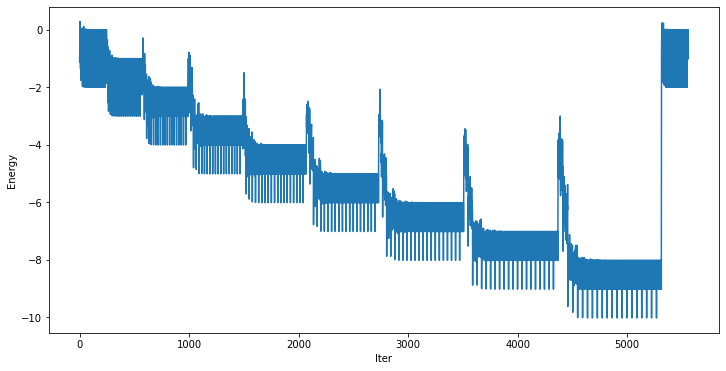

In [16]:
plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])

In [17]:
energy = {}

for iter in range(2, 11, 1):
  result = construct_ising(iter, 1)
  energy[iter] = intermediate_info['energy']

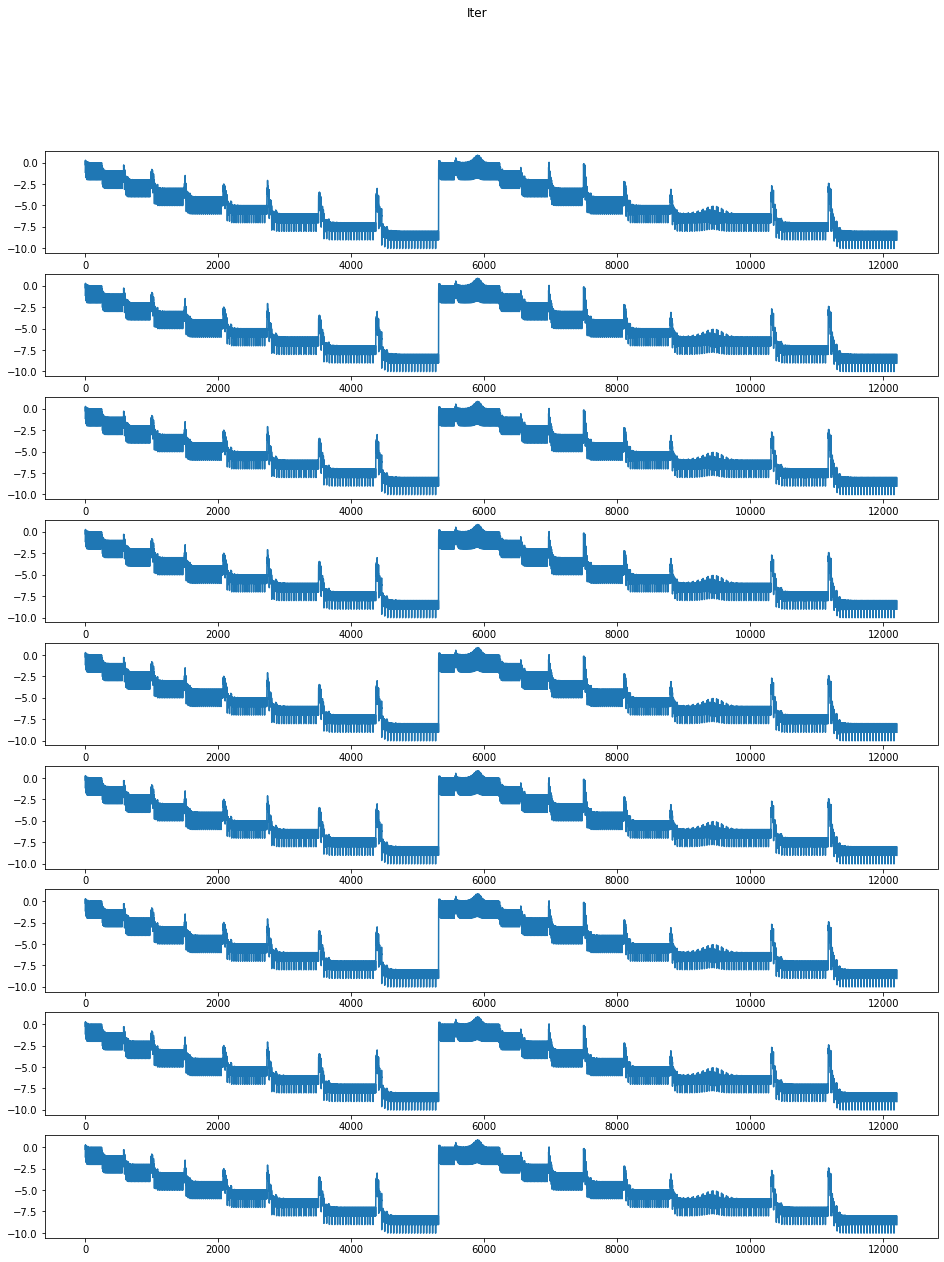

In [18]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize=(16,20))
fig.suptitle('Iter')
ax1.plot(energy[2])
ax2.plot(energy[3])
ax3.plot(energy[4])
ax4.plot(energy[5])
ax5.plot(energy[6])
ax6.plot(energy[7])
ax7.plot(energy[8])
ax8.plot(energy[9])
ax9.plot(energy[10])

plt.show()

#### Setup 2.

The number of the parametrize layers equals the size of the problem $N$.

Example:  for $N=5$, use 5 parametrize layers and 4 entangling layers.

Note: Overparametrization may occur.

In [19]:

construct_ising(3, 3)

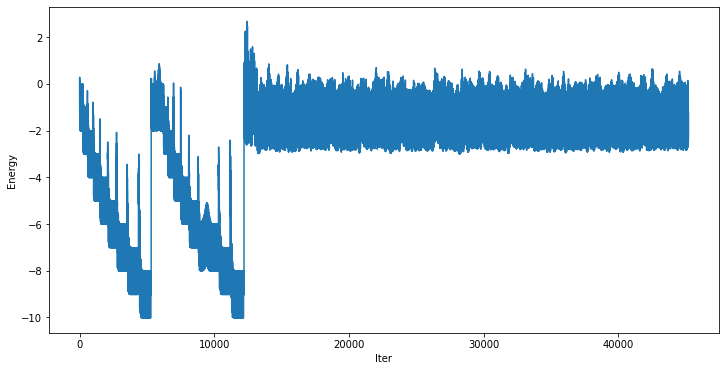

In [20]:
plt.figure(figsize=(12, 6), facecolor='white')
plt.ylabel('Energy')
plt.xlabel('Iter')
plt.plot(intermediate_info['energy'])